In [1]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from gudhi import CubicalComplex
from gudhi.sklearn.cubical_persistence import CubicalPersistence
# from medmnist import ChestMNIST
from PIL import Image
import time
import matplotlib.pyplot as plt

from src.sparse_uplap import *
from src.utils import *

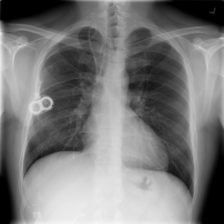

In [2]:
# Load chest X-ray image
image = Image.open("images/chest.png")
image

In [3]:
# Convert image to numpy array
image_array = np.array(image)

In [4]:
# Check the shape of the image: (224, 224)
np.array(image_array).shape

(224, 224)

In [5]:
# Apply max pooling to the image
pool_size = (2, 2)

image_array_2 = max_pool2d(image_array, pool_size, pool_size)
image_array_3 = max_pool2d(image_array_2, pool_size, pool_size)
image_array_4 = max_pool2d(image_array_3, pool_size, pool_size)
image_array_5 = max_pool2d(image_array_4, pool_size, pool_size)
image_array_6 = max_pool2d(image_array_5, pool_size, pool_size)
image_array_7 = max_pool2d(image_array_6, pool_size, pool_size)
image_array_8 = max_pool2d(image_array_7, pool_size, pool_size)

In [6]:
# Create CubicalComplex from the image array
X = CubicalComplex(top_dimensional_cells=image_array).all_cells()

In [7]:
# Create boundary operator, the filtration masks, and the number of filters
bdry_opr, filt_idx_0_2, filt_idx_1_2, num_filt = get_bdry_opr(X, filt_0=20, filt_1=50, filt_2=150)

In [8]:
# Check the shape of the boundary operator
bdry_opr.shape

(62972, 30836)

In [9]:
# Initialize the UpPersistentLaplacianSparse class
uplapclass = UpPersistentLaplacianSparse(bdry_opr, filt_idx_0_2=filt_idx_1_2,
                                         filt_idx_1_2=np.ones(bdry_opr.shape[0], dtype=bool))
time_list_1 = []

k=1

st_1 = time.time()

uplapclass.find_D()
uplapclass.find_root()
uplapclass.uf.find_loops()
uplapclass.uf.find_loops_roots()
uplapclass.find_rel_bdry_opr()
uplapclass.find_diag()

# temp_D = uplapclass.rel_bdry_opr @ np.sqrt(uplapclass.diag)

d = np.sqrt(uplapclass.diag_array)  # Replace with your diagonal entries
rel_bdry_opr_scaled = uplapclass.rel_bdry_opr.data * d[uplapclass.rel_bdry_opr.indices]
temp_D = sp.csr_matrix((rel_bdry_opr_scaled, uplapclass.rel_bdry_opr.indices, uplapclass.rel_bdry_opr.indptr), shape=uplapclass.rel_bdry_opr.shape)

sig = scipy.sparse.linalg.svds(temp_D, k=k, which='LM', return_singular_vectors=False)
# uplapclass.find_up_persistent_Laplacian()
#
for i in range(num_filt):
    uplapclass.add_edge_temp()
    if i % 5000 == 0:
        ed_1 = time.time()

        d = np.sqrt(uplapclass.diag_array)  # Replace with your diagonal entries
        rel_bdry_opr_scaled = uplapclass.rel_bdry_opr.data * d[uplapclass.rel_bdry_opr.indices]
        temp_D = sp.csr_matrix((rel_bdry_opr_scaled, uplapclass.rel_bdry_opr.indices, uplapclass.rel_bdry_opr.indptr), shape=uplapclass.rel_bdry_opr.shape)
        sig = scipy.sparse.linalg.svds(temp_D, k=k, which='LM',
                                       return_singular_vectors=False)
        time_list_1.append(ed_1 - st_1)

et_1 = time.time()
time_list_1.append(et_1 - st_1)

In [10]:
time_list_3 = []
st_2 = time.time()

sub_filt_idx = np.where(uplapclass.filt_idx_1_2 != uplapclass.filt_idx_0_2)[0]
indices_it = iter(sub_filt_idx)
bdry_opr = bdry_opr.astype('float32')
lap = bdry_opr @ np.transpose(bdry_opr)
k=1
eigs = eigsh(lap, k=k, which='LM', return_eigenvectors=False)

for i in range(num_filt):
    edge = next(indices_it)
    lap = compute_up_persistent(lap, edge - i)
    if i % 5000 == 0:
        # print(i)
        eigs = eigsh(lap, k=k, which='LM', return_eigenvectors=False)
        # eigs = scipy.sparse.linalg.svds(lap, k=k, which='SM', return_singular_vectors=False)

        ed_2 = time.time()
        time_list_3.append(ed_2 - st_2)
et_2 = time.time()
time_list_3.append(et_2 - st_2)

In [11]:
steps = [_ for _ in range(0, num_filt, 5000)]
steps.append(num_filt)

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_16663/1797955107.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(steps, time_list_1, label='Computing $B_{1}^{\mathcal{L}^1, \mathcal{K}^1_n}(W_{1}^{\mathcal{L}^1, \mathcal{K}^1_n})^{1/2}$ and the largest singular values')
/tmp/ipykernel_16663/1797955107.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(steps, time_list_3, label='Computing $\Delta_{1, up}^{\mathcal{K}^1_n, \mathcal{L}^1}$ in Schur complement and the largest eigenvalues')


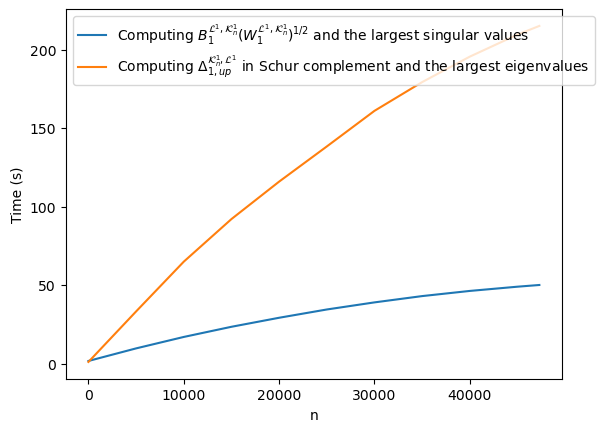

In [12]:
# plt.rcParams['text.usetex'] = True

plt.plot(steps, time_list_1, label='Computing $B_{1}^{\mathcal{L}^1, \mathcal{K}^1_n}(W_{1}^{\mathcal{L}^1, \mathcal{K}^1_n})^{1/2}$ and the largest singular values')
plt.plot(steps, time_list_3, label='Computing $\Delta_{1, up}^{\mathcal{K}^1_n, \mathcal{L}^1}$ in Schur complement and the largest eigenvalues')

plt.xlabel('n')
plt.ylabel('Time (s)')
plt.legend(loc='upper left')
# plt.show()
# plt.savefig('plots/computing_in_windows.png')
plt.savefig('plots/largest_eigenvalues_1_ubuntu.png')